# **Ouroboros EEG-fMRI NF: Predicting EEG activity, fMRI activity and NF scores**

#### Version: 28th October 2022

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through six Notebooks:

*01: Data Analysis*

*02: Classification* (all classification models except neural networks)

*03: Neural Networks*

*04: Regression on fMRI Data*

*05: Regression on EEG Data*

***06: Results***

==============================================================================================

### Notebook 06

# **Results**

## **1. Introduction to Results**

### 1.1 Overview

In this project, we worked with data obtained by **Electroencephalography (EEG)** and **functional Magnetic Resonance Imaging (fMRI)**, two of the major tools used by neuroscientists for brain activity investigation, and with **Neurofeedback (NF) scores** computed using this data. In the first Notebook on Data Analysis, we pointed out the fact that these two techniques allow the investigation of neural activity at two different levels: while EEG measures the electrical activity of the brain, using electrodes placed on the head, fMRI on the other hand measures the activity of the brain indirectly, by detecting the changes in the cerebral blood flow. Therefore, these two approaches are very complementary, and their integration in the field of NF through **EEG-fMRI NF trainings** is particularly promising. 

After using several classification and regression models, we are now ready to summarize our findings. **Throughout these Notebooks, we explored several ways to apply machine learning models to our EEG-fMRI NF dataset, and some of them resulted in interesting predictions**.

### 1.2 Data import

In the following cells, we **define the results path** and the list of subjects. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the raw data path. 
data_path = '../ouroboros_eeg-fmri_nf_raw_data/'

# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_eeg-fmri_nf_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [3]:
# Define the list of subjects. 
subjects = []

for subject_index in range(10):
    if subject_index < 9:
        subjects.append('sub-xp10' + str(subject_index + 1))
    else:
        subjects.append('sub-xp1' + str(subject_index + 1))

print(subjects)

['sub-xp101', 'sub-xp102', 'sub-xp103', 'sub-xp104', 'sub-xp105', 'sub-xp106', 'sub-xp107', 'sub-xp108', 'sub-xp109', 'sub-xp110']


In [4]:
# Define a function to return the middle sections of an image data array. 
def middle_sections(image_data):
    return tuple((np.array(image_data[:, :, :].shape) / 2).astype(int))

In [5]:
# Define a function to display the position of a voxel or cluster, with one image as background. 
def display_voxel_or_cluster_position(voxel_index, background_image, image_data_shape):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

    # Sagittal view. 
    axes[0].imshow(background_image[voxel_index[0], :, :].T, origin = 'lower')
    axes[0].axhline(voxel_index[2], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[0].axvline(voxel_index[1], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[0].scatter(voxel_index[1], voxel_index[2], marker = 'o', c = 'white')
    axes[0].set_title('Sagittal view')

    # Coronal view. 
    axes[1].imshow(background_image[:, voxel_index[1], :].T, origin = 'lower')
    axes[1].axhline(voxel_index[2], 0, image_data_shape[0], color = 'yellow') # Horizontal line through sagittal view. 
    axes[1].axvline(voxel_index[0], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[1].scatter(voxel_index[0], voxel_index[2], marker = 'o', c = 'white')
    axes[1].set_title('Coronal view')

    # Axial view. 
    axes[2].imshow(background_image[:, :, voxel_index[2]], origin = 'lower')
    axes[2].axhline(voxel_index[0], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[2].axvline(voxel_index[1], 0, image_data_shape[0], color = 'yellow') # Vertical line through sagittal view. 
    axes[2].scatter(voxel_index[1], voxel_index[0], marker = 'o', c = 'white')
    axes[2].set_title('Axial view')
    plt.show();

## **2. Classification results**

In the following cells, we load the results from the **Notebook on Classification**, and compare the accuracy of the different classification models. We start with the models using the EEG data as predictors, continue with the models using the fMRI data as predictors, and finally with the models combining both EEG and fMRI data. In the Notebook on Classification, a train/test split was done for each model, and as a consequence, each model has its own baseline. 

### **2.1 Classification based on EEG data**

#### 2.1.1 All subjects, C1 channel

In [6]:
# Load the results from the classification based on EEG data. 
with np.load(results_path + 'classification_with_EEG_predictors_all_subjects_C1_channel.npz', allow_pickle = True) as npz_file:
    data_dict = dict(npz_file.items())

# Store the results as DataFrames. 
knn_results = pd.DataFrame(data_dict['knn_results'], index = subjects, columns = ['knn__n_neighbors', 'test_score', 'baseline'])
dt_results = pd.DataFrame(data_dict['dt_results'], index = subjects, columns = ['dt__max_depth', 'test_score', 'baseline'])
rf_results = pd.DataFrame(data_dict['rf_results'], index = subjects, columns = ['rf__n_estimators', 'test_score', 'baseline'])
svm_results = pd.DataFrame(data_dict['svm_results'], index = subjects, columns = ['svm__C', 'test_score', 'baseline'])
logreg_results = pd.DataFrame(data_dict['logreg_results'], index = subjects, columns = ['logreg__C', 'test_score', 'baseline'])
logreg_probabilities = pd.DataFrame(data_dict['logreg_probabilities'], index = range(40), columns = ['rest', 'task', 'predicted target', 'true target', 'probability of true target value'])

In [7]:
# Create a Pandas DataFrame to hold all the test scores. 
classification_based_on_EEG = pd.DataFrame()
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    classification_based_on_EEG[classification_model] = eval(classification_model + '_results')['test_score']

# Display the DataFrame. 
classification_based_on_EEG

,knn,dt,rf,svm,logreg
sub-xp101,0.550,0.525,0.675,0.725,0.625
sub-xp102,0.675,0.650,0.700,0.550,0.525
sub-xp103,0.725,0.575,0.550,0.725,0.725
sub-xp104,0.700,0.775,0.600,0.600,0.700
sub-xp105,0.750,0.575,0.650,0.725,0.750
sub-xp106,0.550,0.475,0.725,0.700,0.600
sub-xp107,0.550,0.700,0.550,0.650,0.625
sub-xp108,0.650,0.575,0.625,0.675,0.750
sub-xp109,0.475,0.450,0.475,0.375,0.575
sub-xp110,0.400,0.500,0.550,0.425,0.450


In [8]:
# Create a Pandas DataFrame to hold all the baselines. 
classification_based_on_EEG_baselines = pd.DataFrame()
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    classification_based_on_EEG_baselines[classification_model] = eval(classification_model + '_results')['baseline']

In [9]:
# Display the mean test score for the classification models. 
classification_based_on_EEG.mean()

knn       0.6025
dt        0.5800
rf        0.6100
svm       0.6150
logreg    0.6325
dtype: float64

In [10]:
# Display the mean baseline for the classification models. 
classification_based_on_EEG_baselines.mean()

knn       0.4425
dt        0.4400
rf        0.4475
svm       0.4350
logreg    0.4325
dtype: float64

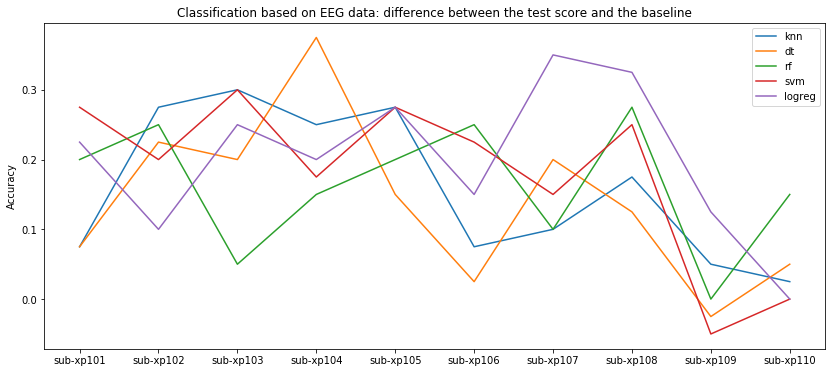

In [11]:
# Display the difference between the test score and the baseline for all subjects and all models. 
plt.figure(figsize = ((14, 6)))
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    plt.plot(classification_based_on_EEG[classification_model] - classification_based_on_EEG_baselines[classification_model], label = classification_model)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Classification based on EEG data: difference between the test score and the baseline');

**Result:** There is a certain variability among the subjects, but overall, the classification models based on EEG data manage to predict the brain states with an accuracy higher than the baseline. All the models seem to have similar levels of accuracy. 

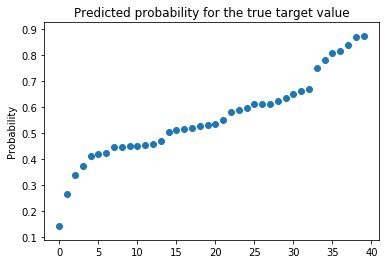

In [12]:
# Display the predicted probability for the true target value, sorted in ascending order. 
plt.scatter(range(0, logreg_probabilities.shape[0]), logreg_probabilities['probability of true target value'].sort_values());
plt.ylabel('Probability')
plt.title('Predicted probability for the true target value');

Most of the time, the probabilities predicted by the logistic regression model have **intermediate values**, neither low nor high. This reflects a certain uncertainty in the determination of the true target class. 

#### 2.1.2 Single subject, all channels

In [13]:
# Load the results from the classification based on EEG data. 
with np.load(results_path + 'classification_with_EEG_predictors_single_subject_all_channels.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())

In [14]:
# Display the difference between the test score and the baseline. 
data_dict['svm_results'][1] - data_dict['svm_results'][2]

0.15000000000000002

**Result:** The SVM model using all EEG channels manages to predict the brain states with an accuracy higher than the baseline. However, if we compare this result to the result obtained with the SVM model using only the C1 channel, we do not see any significative improvement. It seems that the C1 channel alone is sufficient to give good classification results. 

### **2.2 Classification based on fMRI data**

#### 2.2.1 Original voxel size

In [15]:
# Load the results from the classification based on fMRI data. 
with np.load(results_path + 'classification_with_fMRI_predictors_all_subjects_r1.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())
    
# Store the results as DataFrames. 
knn_results = pd.DataFrame(data_dict['knn_results'], index = subjects, columns = ['knn__n_neighbors', 'test_score', 'baseline'])
dt_results = pd.DataFrame(data_dict['dt_results'], index = subjects, columns = ['dt__max_depth', 'test_score', 'baseline'])
rf_results = pd.DataFrame(data_dict['rf_results'], index = subjects, columns = ['rf__n_estimators', 'test_score', 'baseline'])
svm_results = pd.DataFrame(data_dict['svm_results'], index = subjects, columns = ['svm__C', 'test_score', 'baseline'])

In [16]:
# Create a Pandas DataFrame to hold all the test scores. 
classification_based_on_fMRI = pd.DataFrame()
for classification_model in ['knn', 'dt', 'rf', 'svm']:
    classification_based_on_fMRI[classification_model] = eval(classification_model + '_results')['test_score']

# Display the DataFrame. 
classification_based_on_fMRI

,knn,dt,rf,svm
sub-xp101,0.800,0.675,0.875,0.850
sub-xp102,0.600,0.675,0.625,0.800
sub-xp103,0.825,0.825,0.675,0.850
sub-xp104,0.825,0.575,0.550,0.675
sub-xp105,0.825,0.650,0.875,0.825
sub-xp106,0.600,0.650,0.550,0.775
sub-xp107,0.750,0.825,0.775,0.850
sub-xp108,0.675,0.650,0.775,0.875
sub-xp109,0.850,0.650,0.625,0.800
sub-xp110,0.725,0.675,0.700,0.775


In [17]:
# Create a Pandas DataFrame to hold all the baselines. 
classification_based_on_fMRI_baselines = pd.DataFrame()
for classification_model in ['knn', 'dt', 'rf', 'svm']:
    classification_based_on_fMRI_baselines[classification_model] = eval(classification_model + '_results')['baseline']

In [18]:
# Display the mean test score for the classification models. 
classification_based_on_fMRI.mean()

knn    0.7475
dt     0.6850
rf     0.7025
svm    0.8075
dtype: float64

In [19]:
# Display the mean baseline for the classification models. 
classification_based_on_fMRI_baselines.mean()

knn    0.460
dt     0.440
rf     0.455
svm    0.435
dtype: float64

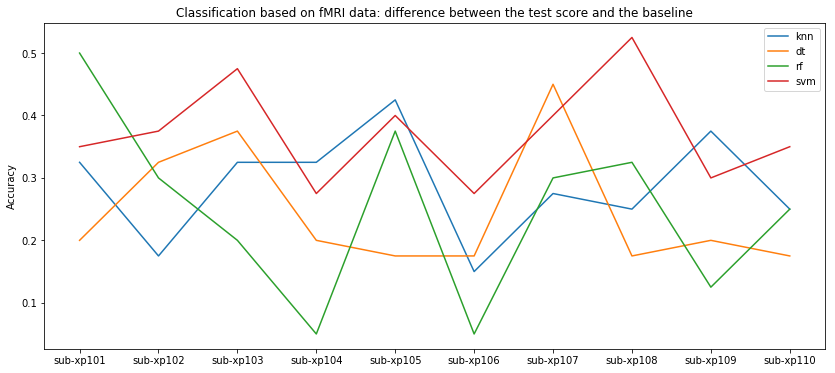

In [20]:
# Display the difference between the test score and the baseline for all subjects and all models. 
plt.figure(figsize = ((14, 6)))
for classification_model in ['knn', 'dt', 'rf', 'svm']:
    plt.plot(classification_based_on_fMRI[classification_model] - classification_based_on_fMRI_baselines[classification_model], label = classification_model)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Classification based on fMRI data: difference between the test score and the baseline');

**Result:** There is a certain variability among the subjects, but overall, the classification models based on fMRI data manage to predict the brain states with an accuracy higher than the baseline. Also, these models seem to perform better than those based on EEG data, which was expected since we have considerably more features in fMRI. 

#### 2.2.2 Voxel size rescaling by a factor 2 or 3

In [21]:
# Load the results from the classification based on fMRI data. 
with np.load(results_path + 'classification_with_fMRI_predictors_all_subjects_r2.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())
    
# Store the results as DataFrames. 
svm_r2_results = pd.DataFrame(data_dict['svm_results'], index = subjects, columns = ['svm__C', 'test_score', 'baseline'])

# Load the results from the classification based on fMRI data. 
with np.load(results_path + 'classification_with_fMRI_predictors_all_subjects_r3.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())
    
# Store the results as DataFrames. 
svm_r3_results = pd.DataFrame(data_dict['svm_results'], index = subjects, columns = ['svm__C', 'test_score', 'baseline'])

In [22]:
# Create a Pandas DataFrame to hold all the test scores. 
classification_based_on_fMRI = pd.DataFrame()
for classification_model in ['svm_r2', 'svm_r3']:
    classification_based_on_fMRI[classification_model] = eval(classification_model + '_results')['test_score']

# Display the DataFrame. 
classification_based_on_fMRI

,svm_r2,svm_r3
sub-xp101,0.850,0.925
sub-xp102,0.775,0.700
sub-xp103,0.675,0.850
sub-xp104,0.825,0.850
sub-xp105,0.850,0.875
sub-xp106,0.775,0.825
sub-xp107,0.900,0.900
sub-xp108,0.775,0.775
sub-xp109,0.850,0.675
sub-xp110,0.750,0.825


In [23]:
# Create a Pandas DataFrame to hold all the baselines. 
classification_based_on_fMRI_baselines = pd.DataFrame()
for classification_model in ['svm_r2', 'svm_r3']:
    classification_based_on_fMRI_baselines[classification_model] = eval(classification_model + '_results')['baseline']

In [24]:
# Display the mean test score for the classification models. 
classification_based_on_fMRI.mean()

svm_r2    0.8025
svm_r3    0.8200
dtype: float64

In [25]:
# Display the mean baseline for the classification models. 
classification_based_on_fMRI_baselines.mean()

svm_r2    0.450
svm_r3    0.435
dtype: float64

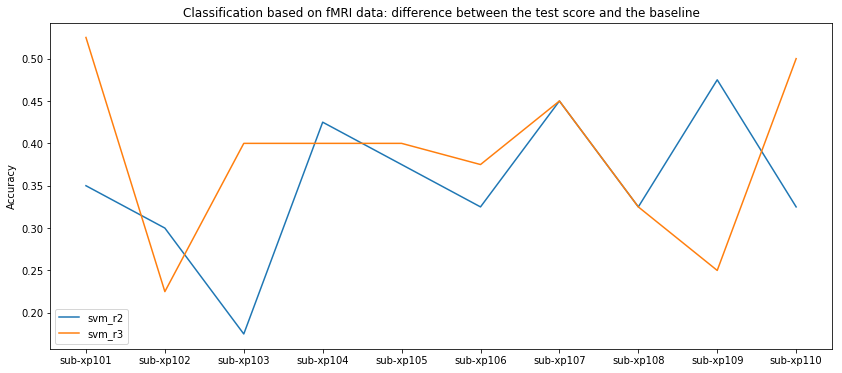

In [26]:
# Display the difference between the test score and the baseline for all subjects and all models. 
plt.figure(figsize = ((14, 6)))
for classification_model in ['svm_r2', 'svm_r3']:
    plt.plot(classification_based_on_fMRI[classification_model] - classification_based_on_fMRI_baselines[classification_model], label = classification_model)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Classification based on fMRI data: difference between the test score and the baseline');

**Result:** Overall, the SVM models based on fMRI data with voxel size rescaling manage to predict the brain states with an accuracy higher than the baseline. The accuracy is more or less at the same levels than the one we obtained with the original voxel size, which is interesting since the datasets with rescaled voxel size are much lighter, allowing for faster computations. 

#### 2.2.3 PCA with 200 or 10 components

In [27]:
# Load the results from the classification based on fMRI data. 
with np.load(results_path + 'classification_with_fMRI_predictors_all_subjects_PCA_200.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())
    
# Store the results as DataFrames. 
svm_pca200_results = pd.DataFrame(data_dict['svm_results'], index = subjects, columns = ['svm__C', 'test_score', 'baseline'])

# Load the results from the classification based on fMRI data. 
with np.load(results_path + 'classification_with_fMRI_predictors_all_subjects_PCA_10.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())
    
# Store the results as DataFrames. 
svm_pca10_results = pd.DataFrame(data_dict['svm_results'], index = subjects, columns = ['svm__C', 'test_score', 'baseline'])

In [28]:
# Create a Pandas DataFrame to hold all the test scores. 
classification_based_on_fMRI = pd.DataFrame()
for classification_model in ['svm_pca200', 'svm_pca10']:
    classification_based_on_fMRI[classification_model] = eval(classification_model + '_results')['test_score']

# Display the DataFrame. 
classification_based_on_fMRI

,svm_pca200,svm_pca10
sub-xp101,0.475,0.750
sub-xp102,0.450,0.700
sub-xp103,0.450,0.550
sub-xp104,0.450,0.725
sub-xp105,0.575,0.825
sub-xp106,0.650,0.600
sub-xp107,0.400,0.875
sub-xp108,0.525,0.775
sub-xp109,0.650,0.750
sub-xp110,0.400,0.550


In [29]:
# Create a Pandas DataFrame to hold all the baselines. 
classification_based_on_fMRI_baselines = pd.DataFrame()
for classification_model in ['svm_pca200', 'svm_pca10']:
    classification_based_on_fMRI_baselines[classification_model] = eval(classification_model + '_results')['baseline']

In [30]:
# Display the mean test score for the classification models. 
classification_based_on_fMRI.mean()

svm_pca200    0.5025
svm_pca10     0.7100
dtype: float64

In [31]:
# Display the mean baseline for the classification models. 
classification_based_on_fMRI_baselines.mean()

svm_pca200    0.4475
svm_pca10     0.4250
dtype: float64

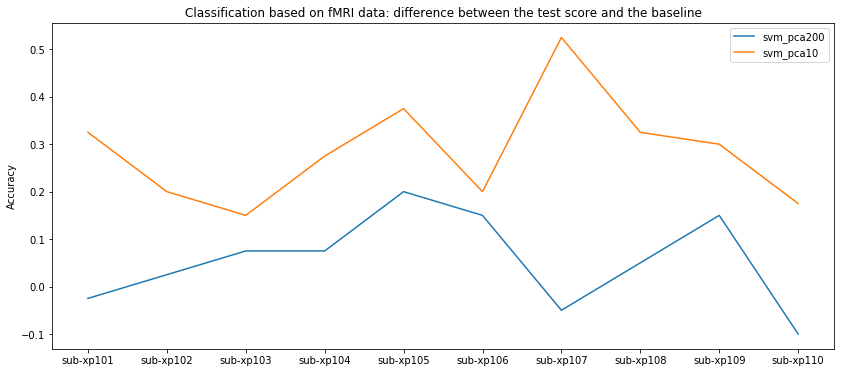

In [32]:
# Display the difference between the test score and the baseline for all subjects and all models. 
plt.figure(figsize = ((14, 6)))
for classification_model in ['svm_pca200', 'svm_pca10']:
    plt.plot(classification_based_on_fMRI[classification_model] - classification_based_on_fMRI_baselines[classification_model], label = classification_model)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Classification based on fMRI data: difference between the test score and the baseline');

**Result:** While the SVM model based on fMRI data transformed through a PCA with 10 components manages to predict the brain states with an accuracy higher than the baseline, the SVM model using a PCA with 200 components do not seem to produce accurate predictions. As we mentioned in the Notebook on Classification, it is very possible that the separating hyperplane of the SVM works better with a few relevant dimensions, while its performance degrades when we add other, less informative dimensions. 

In [33]:
# Load the results from the classification based on fMRI data. 
with np.load(results_path + 'classification_with_fMRI_predictors_all_subjects_PCA_variable.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())
    
# Store the results as DataFrames. 
mean_test_score_by_nb_components = data_dict['mean_test_score_by_nb_components']
mean_baseline_by_nb_components = data_dict['mean_baseline_by_nb_components']

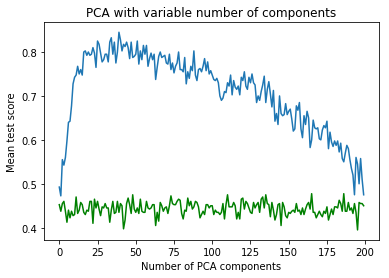

In [34]:
# Plot the results. 
plt.plot(mean_test_score_by_nb_components)
plt.plot(mean_baseline_by_nb_components, color = 'green')
plt.xlabel('Number of PCA components')
plt.ylabel('Mean test score')
plt.title('PCA with variable number of components');

When we plot the accuracy obtained using PCA with different numbers of components, we see that at first, the mean test score rises as the number of PCA components increases. Then, there is a slow decrease, until the mean test score falls near the baseline level. As a possible interpretation, we could imagine that the very first PCA components are particularly informative for the determination of the brain state, while the other components may be associated to neural patterns that are not relevant for our target, and might therefore add noise. 

### **2.3 Classification based on EEG and fMRI data**

In [35]:
# Load the results from the classification based on EEG and fMRI data. 
with np.load(results_path + 'classification_with_combined_EEG_fMRI_predictors_all_subjects.npz', allow_pickle = True) as npz_file:
    data_dict = dict(npz_file.items())
    
# Store the results as DataFrames. 
knn_results = pd.DataFrame(data_dict['knn_results'], index = subjects, columns = ['knn__n_neighbors', 'test_score', 'baseline'])
dt_results = pd.DataFrame(data_dict['dt_results'], index = subjects, columns = ['dt__max_depth', 'test_score', 'baseline'])
rf_results = pd.DataFrame(data_dict['rf_results'], index = subjects, columns = ['rf__n_estimators', 'test_score', 'baseline'])
svm_results = pd.DataFrame(data_dict['svm_results'], index = subjects, columns = ['svm__C', 'test_score', 'baseline'])
logreg_results = pd.DataFrame(data_dict['logreg_results'], index = subjects, columns = ['logreg__C', 'test_score', 'baseline'])
logreg_probabilities = pd.DataFrame(data_dict['logreg_probabilities'], index = range(40), columns = ['rest', 'task', 'predicted target', 'true target', 'probability of true target value'])

In [36]:
# Create a Pandas DataFrame to hold all the test scores. 
classification_based_on_EEG_and_fMRI = pd.DataFrame()
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    classification_based_on_EEG_and_fMRI[classification_model] = eval(classification_model + '_results')['test_score']

# Display the DataFrame. 
classification_based_on_EEG_and_fMRI

,knn,dt,rf,svm,logreg
sub-xp101,0.825,0.700,0.800,0.900,0.775
sub-xp102,0.650,0.575,0.750,0.650,0.750
sub-xp103,0.750,0.775,0.800,0.750,0.650
sub-xp104,0.725,0.575,0.675,0.775,0.625
sub-xp105,0.825,0.775,0.800,0.850,0.700
sub-xp106,0.625,0.750,0.600,0.650,0.725
sub-xp107,0.875,0.825,0.900,0.725,0.800
sub-xp108,0.775,0.650,0.775,0.750,0.725
sub-xp109,0.600,0.725,0.600,0.775,0.700
sub-xp110,0.675,0.575,0.700,0.500,0.550


In [37]:
# Create a Pandas DataFrame to hold all the baselines. 
classification_based_on_EEG_and_fMRI_baselines = pd.DataFrame()
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    classification_based_on_EEG_and_fMRI_baselines[classification_model] = eval(classification_model + '_results')['baseline']

In [38]:
# Display the mean test score for the classification models. 
classification_based_on_EEG_and_fMRI.mean()

knn       0.7325
dt        0.6925
rf        0.7400
svm       0.7325
logreg    0.7000
dtype: float64

In [39]:
# Display the mean baseline for the classification models. 
classification_based_on_EEG_and_fMRI_baselines.mean()

knn       0.4575
dt        0.4350
rf        0.4250
svm       0.4650
logreg    0.4650
dtype: float64

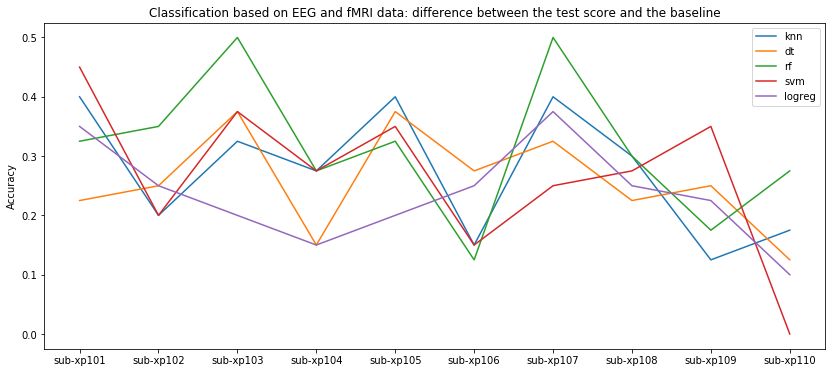

In [40]:
# Display the difference between the test score and the baseline for all subjects and all models. 
plt.figure(figsize = ((14, 6)))
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    plt.plot(classification_based_on_EEG_and_fMRI[classification_model] - classification_based_on_EEG_and_fMRI_baselines[classification_model], label = classification_model)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Classification based on EEG and fMRI data: difference between the test score and the baseline');

**Result:** There is a certain variability among the subjects, but overall, the classification models based on the combination of EEG and fMRI data manage to predict the brain states with an accuracy higher than the baseline. 

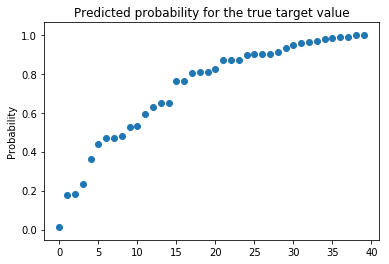

In [41]:
# Display the predicted probability for the true target value, sorted in ascending order. 
plt.scatter(range(0, logreg_probabilities.shape[0]), logreg_probabilities['probability of true target value'].sort_values());
plt.ylabel('Probability')
plt.title('Predicted probability for the true target value');

The probability distribution is different when we use the combined EEG-fMRI data as predictors, in comparison with the EEG bandpowers alone. For a large proportion of data points, we have now a **high predicted probability** for the true target value. It seems that the combination of EEG and fMRI data allows for more certainty in the prediction of the target, as compared with the EEG data alone. 

## **3. Neural networks**

In the following cells, we load the results from the **Notebook on Neural Networks**, and compare the accuracy of the different neural networks models. We start with the models using the fMRI data as predictors, and continue with the models using the EEG data as predictors. In the Notebook on Neural Networks, a train/test split was done for each model, and as a consequence, each model has its own baseline. 

### **3.1 Neural networks based on fMRI data**

In [42]:
# Load the results from the neural networks based on fMRI data. 
with np.load(results_path + 'neural_networks_with_fMRI_predictors_single_subject.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())

# Test scores. 
test_score_dense1 = data_dict['test_score_dense1']
test_score_dense2 = data_dict['test_score_dense2']
test_score_dense3 = data_dict['test_score_dense3']
test_score_dense4 = data_dict['test_score_dense4']

# Target predictions. 
y_pred_dense1 = data_dict['y_pred_dense1']
y_pred_dense2 = data_dict['y_pred_dense2']
y_pred_dense3 = data_dict['y_pred_dense3']
y_pred_dense4 = data_dict['y_pred_dense4']

# Baseline. 
baseline_dense1 = data_dict['neural_networks_baseline1']
baseline_dense2 = data_dict['neural_networks_baseline2']
baseline_dense3 = data_dict['neural_networks_baseline3']
baseline_dense4 = data_dict['neural_networks_baseline4']

In [43]:
# Create a Pandas Series to hold all the test scores. 
neural_networks_based_on_fMRI = pd.Series()
for neural_network_model in ['dense1', 'dense2', 'dense3', 'dense4']:
    neural_networks_based_on_fMRI[neural_network_model] = eval('test_score_' + neural_network_model)

# Display the DataFrame. 
neural_networks_based_on_fMRI

dense1    0.8500000238418579
dense2                 0.875
dense3     0.675000011920929
dense4    0.7250000238418579
dtype: object

In [44]:
# Create a Pandas Series to hold all the baselines. 
neural_networks_based_on_fMRI_baselines = pd.Series()
for neural_network_model in ['dense1', 'dense2', 'dense3', 'dense4']:
    neural_networks_based_on_fMRI_baselines[neural_network_model] = eval('baseline_' + neural_network_model)

# Display the DataFrame. 
neural_networks_based_on_fMRI_baselines

dense1    0.425
dense2    0.425
dense3     0.05
dense4     0.25
dtype: object

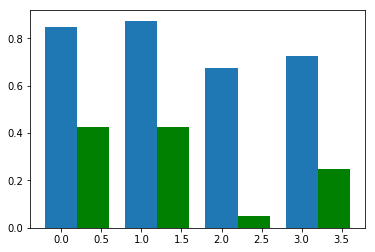

In [45]:
# Display the difference between the test score and the baseline for all models. 
plt.bar([0, 1, 2, 3], neural_networks_based_on_fMRI, width = 0.4)
plt.bar([0.4, 1.4, 2.4, 3.4], neural_networks_based_on_fMRI_baselines, width = 0.4, color = 'green');

**Result:** The neural networks models based on fMRI data manage to predict the brain states, the specific blocks and the block positions with an accuracy higher than the baseline. 

### **3.2 Neural networks based on EEG data**

In [46]:
# Load the results from the neural networks based on EEG data. 
with np.load(results_path + 'neural_networks_with_EEG_predictors_single_subject.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())

# Test scores. 
test_score_dense1 = data_dict['test_score_dense1']
test_score_dense2 = data_dict['test_score_dense2']
test_score_dense3 = data_dict['test_score_dense3']
test_score_dense4 = data_dict['test_score_dense4']

# Target predictions. 
y_pred_dense1 = data_dict['y_pred_dense1']
y_pred_dense2 = data_dict['y_pred_dense2']
y_pred_dense3 = data_dict['y_pred_dense3']
y_pred_dense4 = data_dict['y_pred_dense4']

# Baseline. 
baseline_dense1 = data_dict['neural_networks_baseline1']
baseline_dense2 = data_dict['neural_networks_baseline2']
baseline_dense3 = data_dict['neural_networks_baseline3']
baseline_dense4 = data_dict['neural_networks_baseline4']

In [47]:
# Create a Pandas Series to hold all the test scores. 
neural_networks_based_on_EEG = pd.Series()
for neural_network_model in ['dense1', 'dense2', 'dense3', 'dense4']:
    neural_networks_based_on_EEG[neural_network_model] = eval('test_score_' + neural_network_model)

# Display the DataFrame. 
neural_networks_based_on_EEG

dense1     0.6000000238418579
dense2     0.6499999761581421
dense3                  0.125
dense4    0.32499998807907104
dtype: object

In [48]:
# Create a Pandas Series to hold all the baselines. 
neural_networks_based_on_EEG_baselines = pd.Series()
for neural_network_model in ['dense1', 'dense2', 'dense3', 'dense4']:
    neural_networks_based_on_EEG_baselines[neural_network_model] = eval('baseline_' + neural_network_model)

# Display the DataFrame. 
neural_networks_based_on_EEG_baselines

dense1     0.4
dense2     0.4
dense3    0.05
dense4    0.25
dtype: object

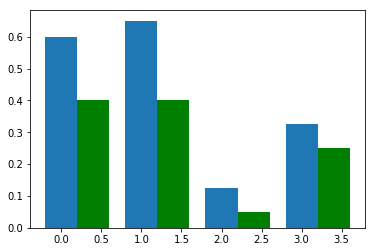

In [49]:
# Display the difference between the test score and the baseline for all models. 
plt.bar([0, 1, 2, 3], neural_networks_based_on_EEG, width = 0.4)
plt.bar([0.4, 1.4, 2.4, 3.4], neural_networks_based_on_EEG_baselines, width = 0.4, color = 'green');

**Result:** The neural networks models based on EEG data manage to predict the brain states, the specific blocks and the block positions with an accuracy higher than the baseline. 

## **4. Regression on fMRI data results**

In the following cells, we load the results from the **Notebook on Regression with fMRI predictors**, and compare the accuracy of the different regression models. We start with the models for EEG data prediction, and we continue with the models for fMRI and EEG NF scores prediction. 

### **4.1 Single subject, EEG data prediction**

In [50]:
# Load the results from the regression based on fMRI data, for a single subject. 
with np.load(results_path + 'regression_with_fMRI_predictors_single_subject_target_EEG_data.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())

# Example subject. 
subject_index = data_dict['subject_index']

# Baseline. 
rss_baseline = data_dict['rss_baseline']

# Linear regression. 
rss_lr = data_dict['rss_lr']
r2_lr = data_dict['r2_lr']
coef_lr = data_dict['coef_lr']
coefficients_image_lr = data_dict['coefficients_image_lr']

# Regression with Huber loss. 
rss_huber = data_dict['rss_huber']
r2_huber = data_dict['r2_huber']
coef_huber = data_dict['coef_huber']
coefficients_image_huber = data_dict['coefficients_image_huber']

# Ridge regression. 
rss_ridge = data_dict['rss_ridge']
r2_ridge = data_dict['r2_ridge']
coef_ridge = data_dict['coef_ridge']
coefficients_image_ridge = data_dict['coefficients_image_ridge']

# Lasso regression. 
rss_lasso = data_dict['rss_lasso']
r2_lasso = data_dict['r2_lasso']
coef_lasso = data_dict['coef_lasso']
coefficients_image_lasso = data_dict['coefficients_image_lasso']

In [51]:
# Display the example subject. 
subject_index

array('sub-xp101', dtype='<U9')

In [52]:
# Display the R^2 measure of the different regression models. 
r2_models = pd.DataFrame([r2_lr, r2_huber, r2_ridge, r2_lasso], columns = ['R^2 measure'], 
                          index = ['Linear regression', 'Regression with Huber loss', 'Ridge regression', 'Lasso regression'])
r2_models

,R^2 measure
Linear regression,0.279186
Regression with Huber loss,0.257105
Ridge regression,0.279126
Lasso regression,0.089743


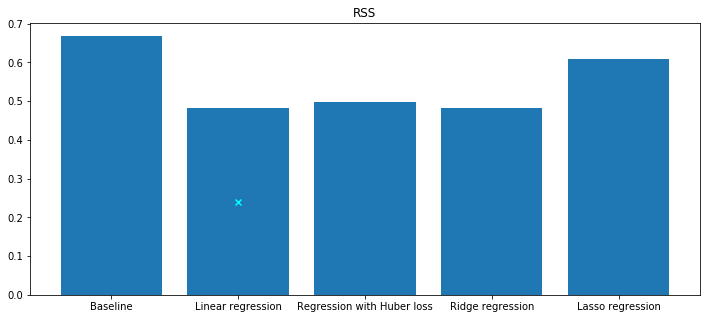

In [53]:
# Display the RSS measure of the different regression models. 
rss_models = pd.DataFrame([rss_baseline, rss_lr, rss_huber, rss_ridge, rss_lasso], columns = ['RSS measure'], 
                           index = ['Baseline', 'Linear regression', 'Regression with Huber loss', 'Ridge regression', 'Lasso regression'])
plt.figure(figsize = (12, 5))
plt.bar(rss_models.index, rss_models['RSS measure'])

# Point the best model on the graph according to the RSS measure. 
plt.scatter(rss_models.idxmin(), rss_models.min() / 2, marker = 'x', c = 'cyan', zorder = 10)
plt.title('RSS');

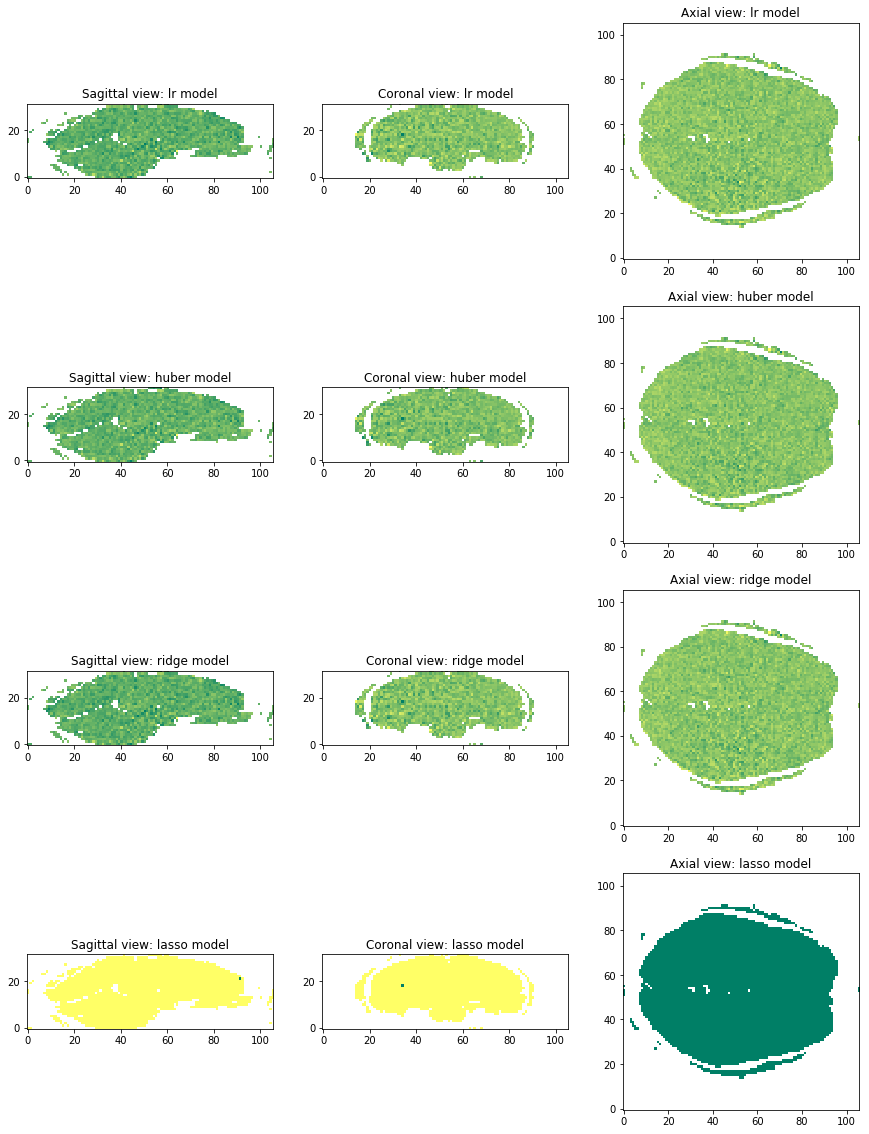

In [54]:
# Display the coefficient images for all the models. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all the models. 
for regression_model in ['lr', 'huber', 'ridge', 'lasso']:
    
    # Retrieve the coefficient image and the middle section coordinates. 
    image_data = eval('coefficients_image_' + regression_model)
    middle_coord = middle_sections(image_data)
    
    axes[counter, 0].imshow(image_data[middle_coord[0], :, :].T, origin = 'lower', cmap = 'summer')
    axes[counter, 0].set_title('Sagittal view: ' + regression_model + ' model')
    axes[counter, 1].imshow(image_data[:, middle_coord[1], :].T, origin = 'lower', cmap = 'summer')
    axes[counter, 1].set_title('Coronal view: ' + regression_model + ' model')
    axes[counter, 2].imshow(image_data[:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
    axes[counter, 2].set_title('Axial view: ' + regression_model + ' model');
    
    # Increment. 
    counter += 1

**Result:** The regression models based on fMRI data manage to predict the selected EEG frequency band, here the alpha band, with an accuracy higher than the baseline. In comparison with the other regression models, the Lasso does not appear to produce very relevant results in this setup. 

### **4.2 All subjects, EEG data prediction**

In [55]:
# Load the results from the regression based on fMRI data, for all subjects and all EEG frequency bands. 
with open(results_path + 'regression_with_fMRI_predictors_all_subjects_target_EEG_data.p', 'rb') as file:
    lr_results_at_subject_level = pickle.load(file)

In [56]:
# Define a function to display the R^2 value for all subjects, for a certain target band. 
def plot_r2_for_all_subjects(target_band_index):
    color_names = ['blue', 'green', 'gold', 'orange', 'red']
    r2_lr_all_subjects = []
    for subject_index in subjects:
        r2_lr_all_subjects.append(lr_results_at_subject_level[subject_index][target_band_index]['r2_lr'])
    plt.figure(figsize = (15, 8))
    plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects, color = color_names[target_band_index])
    plt.title(target_bands_names[target_band_index]);

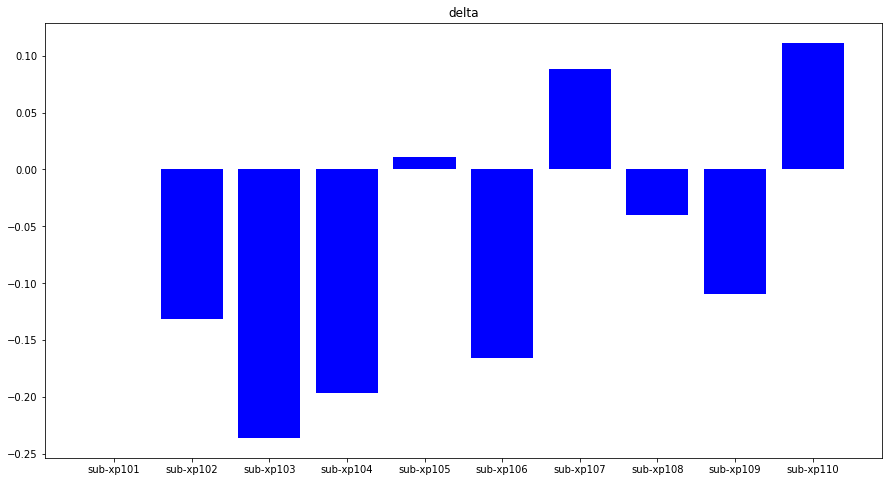

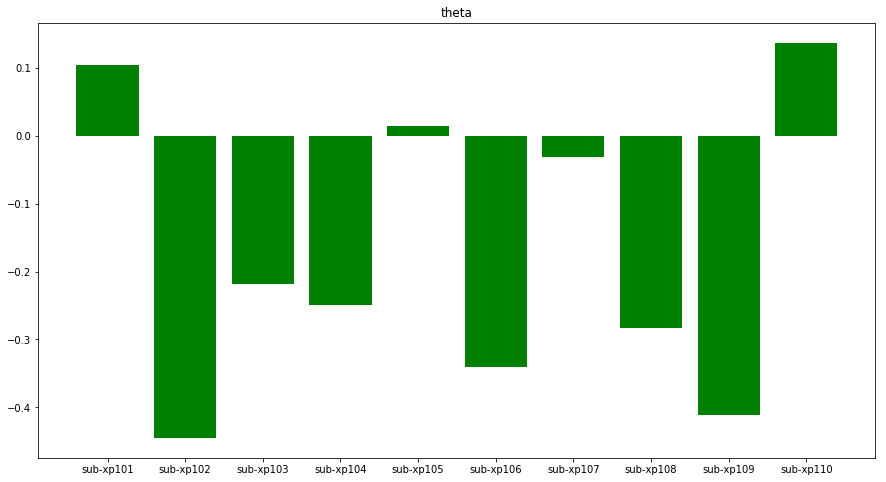

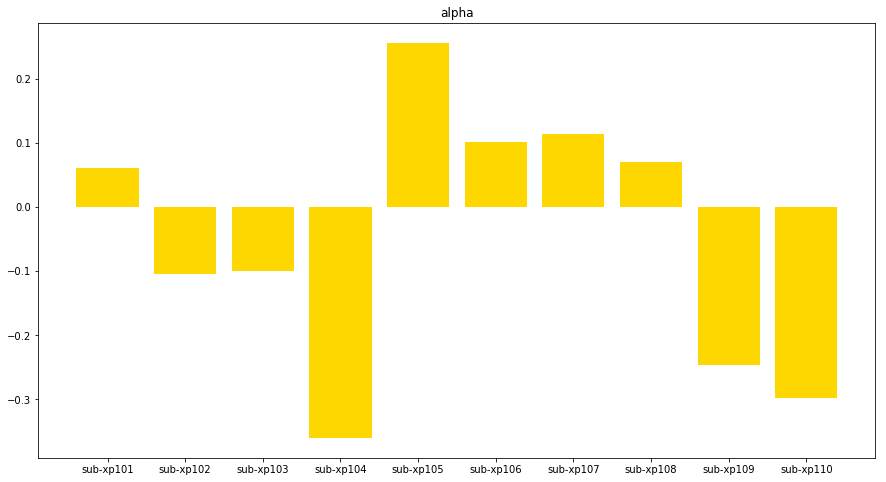

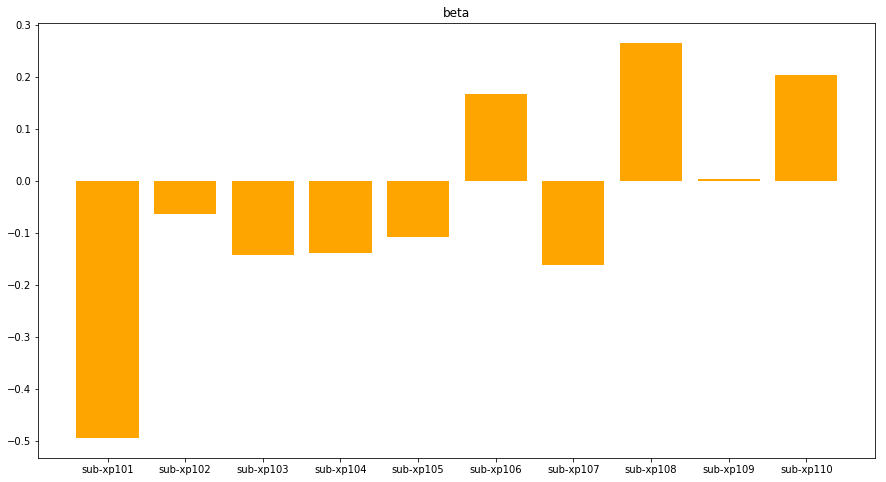

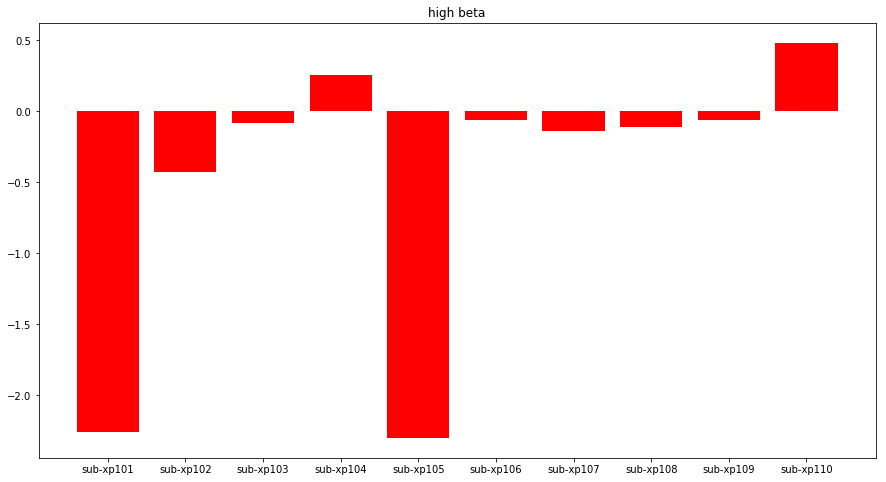

In [57]:
# Define the target bands names. 
target_bands_names = np.array(['delta', 'theta', 'alpha', 'beta', 'high beta'])

# Display the R^2 value for all subjects and all EEG frequency bands. 
for target_band_index in range(5):
    plot_r2_for_all_subjects(target_band_index)

**Result:** The R^2 measure is very variable, with a high predictability in some cases, and a low or even negative predictability in others. It is difficult to find a general pattern across subjects or frequency bands. 

### **4.3 All subjects, NF scores prediction**

#### 4.3.1 fMRI NF scores 

In [58]:
# Load the results from the regression based on fMRI data. 
with open(results_path + 'regression_with_fMRI_predictors_all_subjects_target_fMRI_NF_scores.p', 'rb') as file:
    lr_all_subjects_results = pickle.load(file)

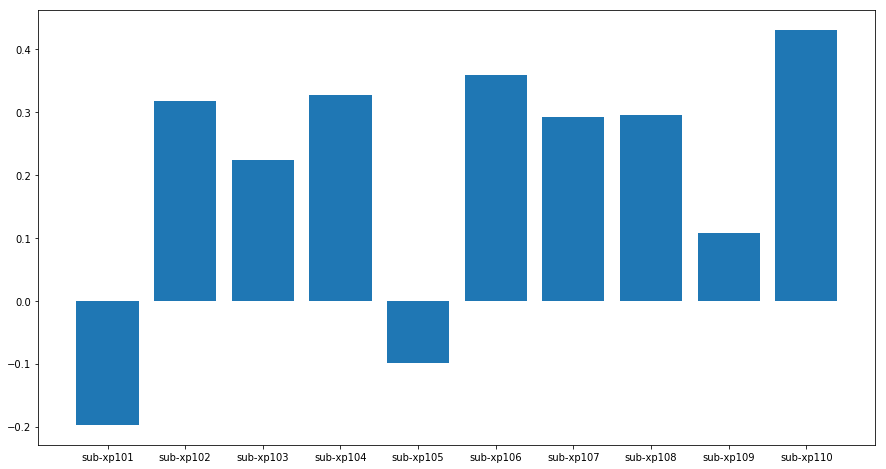

In [59]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects:
    r2_lr_all_subjects.append(lr_all_subjects_results[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects);

**Result:** Overall, the regression models based on fMRI data manage to predict the fMRI NF scores with an accuracy higher than the baseline. We must remember that these NF scores were computed using the fMRI data in the first place. 

#### 4.3.2 EEG NF scores 

In [60]:
# Load the results from the regression based on fMRI data. 
with open(results_path + 'regression_with_fMRI_predictors_all_subjects_target_EEG_NF_scores.p', 'rb') as file:
    lr_all_subjects_results = pickle.load(file)

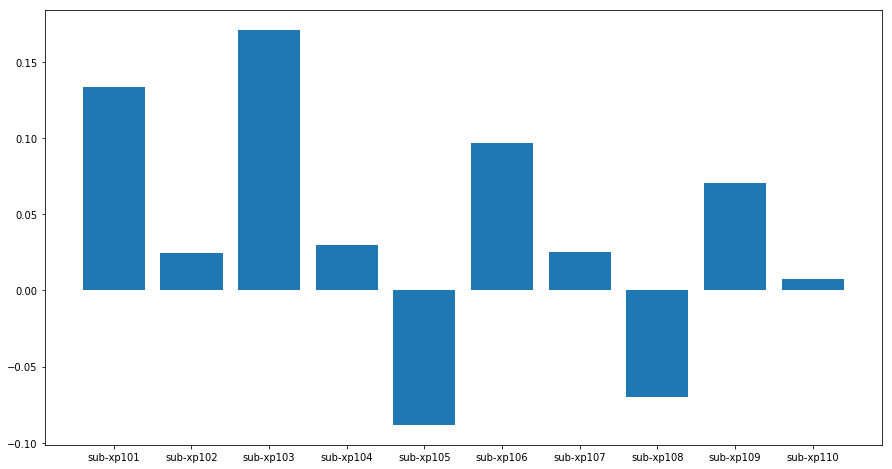

In [61]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects:
    r2_lr_all_subjects.append(lr_all_subjects_results[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects);

**Result:** Overall, the regression models based on fMRI data manage to predict the EEG NF scores with an accuracy higher than the baseline. 

## **5. Regression on EEG data results**

In the following cells, we load the results from the **Notebook on Regression with EEG predictors**, and compare the accuracy of the different regression models. We start with the models for fMRI data prediction, and we continue with the models for EEG and fMRI NF scores prediction. 

### **5.1 Single subject, fMRI data prediction**

In [62]:
# Load the results from the regression based on EEG data, for a single subject. 
with np.load(results_path + 'regression_with_EEG_predictors_single_subject_target_fMRI_data.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())

# Example subject. 
subject_index = data_dict['subject_index']

# Peak voxel. 
peak_voxel = data_dict['peak_voxel']
reconstructed_image = data_dict['reconstructed_image']

# Baseline. 
rss_baseline = data_dict['rss_baseline']

# Linear regression. 
rss_lr = data_dict['rss_lr']
r2_lr = data_dict['r2_lr']
coef_lr = data_dict['coef_lr']

# Regression with Huber loss. 
rss_huber = data_dict['rss_huber']
r2_huber = data_dict['r2_huber']
coef_huber = data_dict['coef_huber']

# Ridge regression. 
rss_ridge = data_dict['rss_ridge']
r2_ridge = data_dict['r2_ridge']
coef_ridge = data_dict['coef_ridge']

In [63]:
# Display the example subject. 
subject_index

array('sub-xp101', dtype='<U9')

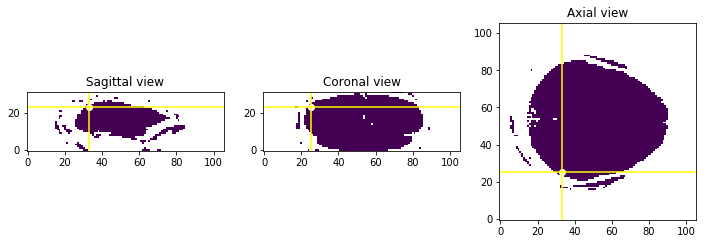

In [64]:
# Display the position of the peak voxel. 
display_voxel_or_cluster_position(peak_voxel, reconstructed_image, reconstructed_image.shape)

In [65]:
# Display the R^2 measure of the different regression models. 
r2_models = pd.DataFrame([r2_lr, r2_huber, r2_ridge], columns = ['R^2 measure'], 
                          index = ['Linear regression', 'Regression with Huber loss', 'Ridge regression'])
r2_models

,R^2 measure
Linear regression,-0.009551
Regression with Huber loss,-0.018424
Ridge regression,-0.007403


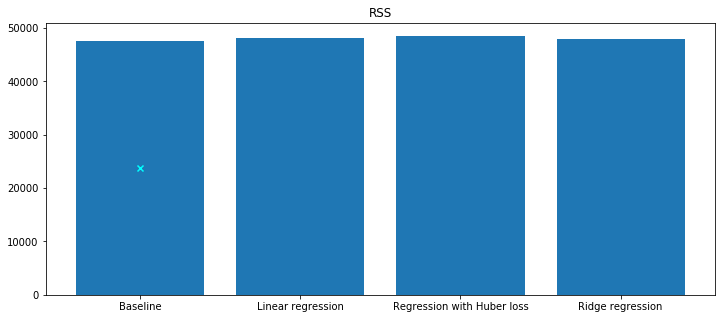

In [66]:
# Display the RSS measure of the different regression models. 
rss_models = pd.DataFrame([rss_baseline, rss_lr, rss_huber, rss_ridge], columns = ['RSS measure'], 
                           index = ['Baseline', 'Linear regression', 'Regression with Huber loss', 'Ridge regression'])
plt.figure(figsize = (12, 5))
plt.bar(rss_models.index, rss_models['RSS measure'])

# Point the best model on the graph according to the RSS measure. 
plt.scatter(rss_models.idxmin(), rss_models.min() / 2, marker = 'x', c = 'cyan', zorder = 10)
plt.title('RSS');

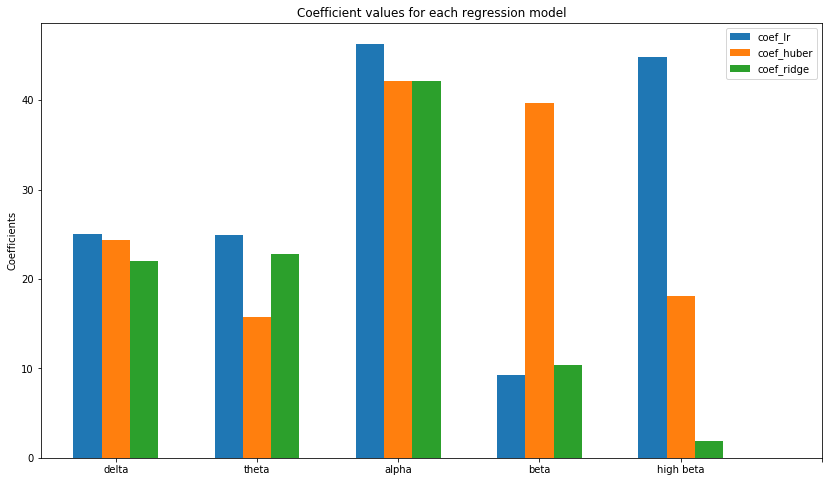

In [67]:
# Group all the coefficients in a dictionary. 
peak_voxel_results = dict({'coef_lr': coef_lr,
                           'coef_huber': coef_huber,
                           'coef_ridge': coef_ridge})

# Display the results in a graph. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (14, 8))
x_coord = np.array(range(0, 5))

# Iterate through all linear models. 
for linear_model in ['coef_lr', 'coef_huber', 'coef_ridge']:
    axes.bar(x_coord, peak_voxel_results[linear_model], width = 0.2, label = linear_model)
    x_coord = x_coord + 0.2

# Add labels and title. 
axes.set_xticks(np.array(range(0, 6)) + 0.2)
axes.set_xticklabels(['delta', 'theta', 'alpha', 'beta', 'high beta'])
axes.set_ylabel('Coefficients')
axes.legend()
axes.set_title('Coefficient values for each regression model');

**Result:** The regression models based on EEG data do not manage to predict the BOLD signal of the peak voxel with an accuracy higher than the baseline. 

### **5.2 All subjects, fMRI data prediction**

In [68]:
# Load the results from the regression based on EEG data, for all subjects. 
with open(results_path + 'regression_with_EEG_predictors_all_subjects_target_fMRI_data.p', 'rb') as file:
    lr_results_at_subject_level = pickle.load(file)

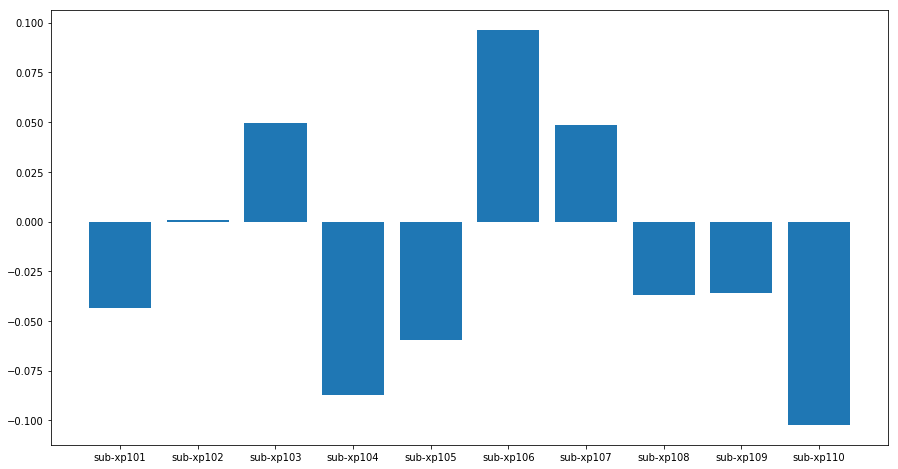

In [69]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects:
    r2_lr_all_subjects.append(lr_results_at_subject_level[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects);

**Result:** Overall, the regression models based on EEG data do not manage to predict the BOLD signal of the peak voxel with an accuracy higher than the baseline. 

### **5.3 All subjects, NF scores prediction**

#### 5.3.1 EEG NF scores

In [70]:
# Load the results from the regression based on EEG data, for all subjects. 
with open(results_path + 'regression_with_EEG_predictors_all_subjects_target_EEG_NF_scores.p', 'rb') as file:
    lr_all_subjects_results = pickle.load(file)

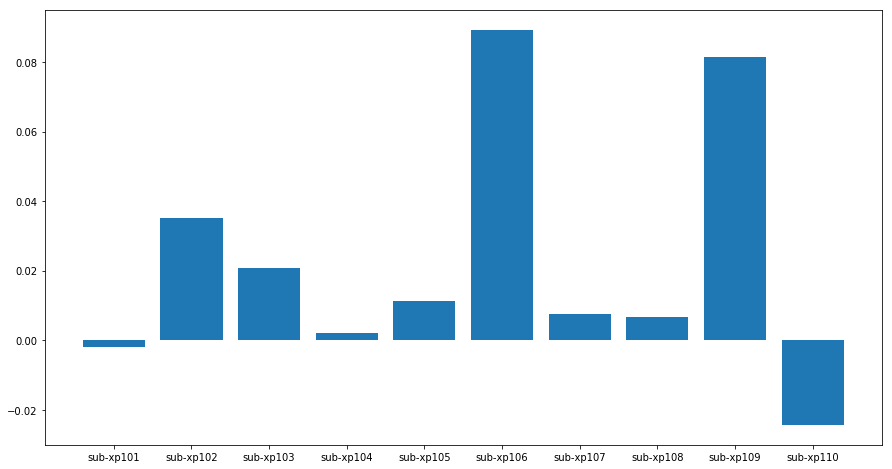

In [71]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects:
    r2_lr_all_subjects.append(lr_all_subjects_results[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects);

**Result:** Overall, the regression models based on EEG data manage to predict the EEG NF scores with an accuracy higher than the baseline. We must remember that these NF scores were computed using the EEG data in the first place. 

#### 5.3.2 fMRI NF scores

In [72]:
# Load the results from the regression based on EEG data, for all subjects. 
with open(results_path + 'regression_with_EEG_predictors_all_subjects_target_fMRI_NF_scores.p', 'rb') as file:
    lr_all_subjects_results = pickle.load(file)

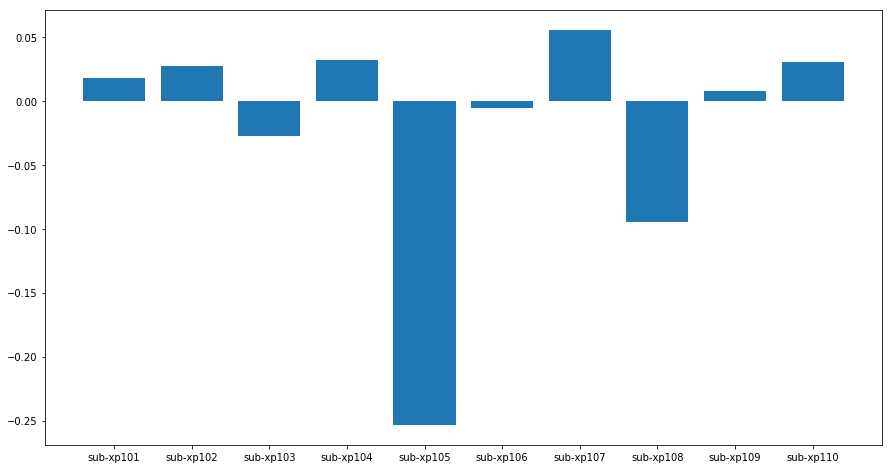

In [73]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects:
    r2_lr_all_subjects.append(lr_all_subjects_results[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects);

**Result:** Overall, the regression models based on EEG data do not manage to predict the fMRI NF scores with an accuracy higher than the baseline. 

## **6. Discussion**

Overall, **classification models** predicted the brain state with an accuracy higher than the baseline, whether we used as predictors the EEG data, the fMRI data with the original voxel size, the fMRI data with voxel size rescaled by a factor 2 or 3, or the fMRI data transformed through a PCA with 10 components. However, the PCA with 200 components did not give good results, maybe indicating that the very first PCA components are particularly relevant for the determination of the brain state, while the other components add mostly noise. Of course, throughout this project we defined the brain state in an extremely specific manner, as the state of the brain in the rest condition versus the state of the brain in the NF task condition. Other experimental setups could lead to very different results. Nevertheless, since NF training allows the subject to learn self-regulation by reacting to his/her own brain activity, it is somewhat reassuring that this brain activity shows clear differences between the rest blocks and the NF blocks. 

The **neural networks models** based either on fMRI or EEG data also predicted the brain state with an accuracy higher than the baseline, and went even further. Using 2-layer dense neural networks, we managed to predict when a single subject was at a specific block of the eegfmriNF run, and when the same subject was at the beginning or at the end of a rest block or a task block. 

The **regression models based on fMRI data** showed contrasted results. While they manage to predict both fMRI NF scores and EEG NF scores, the prediction of EEG data appears to be of very variable quality. It is interesting to notice that, while the dimensionality of the fMRI data is much higher than the dimensionality of the EEG data, the fMRI BOLD signal is still not sufficient to evaluate accurately the EEG bandpowers in all situations. Nevertheless, we can easily imagine all kinds of improvements in the machine learning pipeline. In particular, focusing on specific brain regions, for example the cortical regions which are directly responsible of the EEG signal measured through a channel of interest, would seem like a sensible thing to try. 

The **regression models based on EEG data** performed poorly when trying to predict the fMRI data or the fMRI NF scores. Still, they manage to predict the EEG NF scores, which is reassuring since the EEG data was used to compute these scores in the first place. Interestingly, in other EEG-fMRI datasets, the prediction of fMRI signal based on EEG signal appears to be far better. How could we explain this difference? Is it related to the relative distribution of the bandpowers, which varies greatly between sleep, rest and different sorts of tasks? Since EEG is a relatively cheap and easy to deploy technique, it could be very interesting to know to which extent EEG data can predict an activity in the realm of fMRI, a much more sophisticated technique that requires an expensive machine and adequate facilities. 

This project also raises **multiple questions**. Can we apply machine learning models to all sorts of cross-modality NF datasets, or to datasets including both neurofeedback and biofeedback? If we applied these techniques to brain maps normalized on a common template, could we make meaningful comparisons between subjects, and maybe transfer the model knowledge from one subject to another? In particular, would it be possible to train machine learning models on some EEG-fMRI NF dataset, and then use these models to predict EEG activity, fMRI activity and NF scores on another dataset of new and unseen subjects?

It is probable that **more opportunities for data analysis and machine learning will arise** when more and more researchers will store and share their data in open data repositories like OpenNeuro. Since we can expect a growing interest for EEG-fMRI NF research works, hopefully the cross-modality NF studies will also become more frequent, allowing machine learning models to be applied on a larger scale on this type of datasets. 

## **7. Conclusion**

This project demonstrated that it is possible to **apply machine learning models to a given EEG-fMRI NF dataset, and to obtain interesting predictions**. Classification models, based either on EEG or fMRI data, can be used to predict the brain state, i.e. the experimental stage that the subject is currently in, with an accuracy higher than the baseline. Neural networks models based on EEG or fMRI data can go even further, and predict in particular the specific experimental block. Regression models based on fMRI data can predict all NF scores, while regression models based on EEG data can only predict EEG NF scores. Overall, the successes and limitations of these models seem to prove that **machine learning can be used to extract subtle patterns from EEG and fMRI data in the context of NF training**, but that in our case, classification gives better results than regression. 

As we mentioned in the introduction of the first Notebook, NF shows promising results for a variety of indications, and the combination of EEG and fMRI could extend even further the possibilities of this brain training technology. Machine learning could provide a link between EEG activity, fMRI activity and NF scores, and eventually be used to **fine-tune NF protocols in cross-modality setups using two or more neuroimaging techniques**. This project was conducted on a specific EEG-fMRI NF dataset, but the analyses developed in these Notebooks could likely be applied to other NF studies. Therefore, they might present an interest for the neuroimaging community involved in NF research, as well as for data scientists and machine learning developers. 